In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [3]:
df = pd.read_csv('Datasets/sars_cov_ML_dataset.csv')
df

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.869666
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.882397
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.008774
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.022276
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.950782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.974694
114,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.995679
115,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.939302
116,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.970616


In [12]:
X = df.drop(columns=['pIC50'])
y = df['pIC50']

In [13]:
X.shape

(118, 881)

In [14]:
from sklearn.feature_selection import VarianceThreshold

selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_var = selection.fit_transform(X)

In [15]:
X_var.shape

(118, 197)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_var, y, test_size=0.2, random_state=21)

In [35]:
np.random.seed(7)

model = RandomForestRegressor(n_estimators=100)
model.fit(X=X_train, y=y_train)
r2 = model.score(X=X_test, y=y_test)

r2

0.7048746946460105

In [40]:
import optuna
from sklearn.metrics import mean_squared_error

def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds, squared=False)
    
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best hyperparameters: ", study.best_params)
print("Best RMSE: ", study.best_value)

[I 2024-06-22 20:03:22,730] A new study created in memory with name: no-name-69860a1c-bb31-4766-bd3a-1dd265bdc927
[I 2024-06-22 20:03:22,949] Trial 0 finished with value: 0.6365733955074758 and parameters: {'n_estimators': 167, 'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.6365733955074758.
[I 2024-06-22 20:03:23,377] Trial 1 finished with value: 0.7459014570032335 and parameters: {'n_estimators': 347, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.6365733955074758.
[I 2024-06-22 20:03:23,598] Trial 2 finished with value: 0.704598185755171 and parameters: {'n_estimators': 170, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6365733955074758.
[I 2024-06-22 20:03:23,736] Trial 3 finished with value: 0.6044237505868901 and parameters: {'n_estimators': 111, 'max_depth': 18, 'min

Best hyperparameters:  {'n_estimators': 313, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best RMSE:  0.5714527873667319


In [43]:
best_params = study.best_params

best_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42
)

best_model.fit(X_train, y_train)
r2 = best_model.score(X=X_test, y=y_test)
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("R2 with best hyperparameters: ", r2)
print("RMSE with best hyperparameters: ", rmse)

R2 with best hyperparameters:  0.7278656108394941
RMSE with best hyperparameters:  0.5714527873667319


<function matplotlib.pyplot.show(close=None, block=None)>

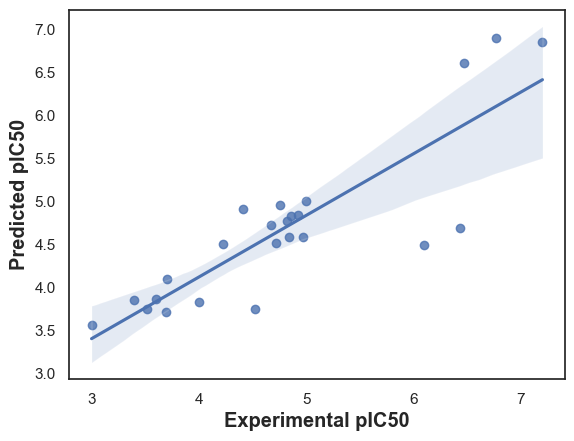

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred)
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
plt.show